<a href="https://colab.research.google.com/github/StephenTGibson/MScDataSci_21-22/blob/main/COMP702-MScProject/PINN_method_for_1D_Burgers'_equation_inverse_problem_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on method presented in:  
*Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations*  
https://www.sciencedirect.com/science/article/pii/S0021999118307125?casa_token=IF_2eTCwVfkAAAAA:-AYLqjAlpXcFYBHje4sO2kMjqH3k0pdFQ7Qdpw1MazWxIGPwacb3Cp0gCtFRbNDAVLSsjCWU0g

In [ ]:
# install devito
!pip install devito &> /dev/null

In [1]:
# import required libraries and tools
import numpy as np
from numpy.random import default_rng
rng = default_rng()

import pandas as pd

from time import perf_counter

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns

import torch
from torch import nn

# from devito import Grid, TimeFunction, Operator, Constant, Eq, solve, first_derivative, left

import sys
!git clone https://github.com/StephenTGibson/MScDataSci_21-22.git &> /dev/null
sys.path.append('/content/MScDataSci_21-22/COMP702-MScProject')
import utilityFunctions
import physicsInformedNeuralNetworks

from google.colab import drive
drive.mount('/content/gdrive')

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device

Mounted at /content/gdrive


## Finite difference solver

In [ ]:
# solves 1D Burgers' equations using devito finite difference computation
def devitoSolver_1D_Burgers(tResolution, xResolution, tMin, tMax, xMin, xMax, l1, l2):
    # define discretisation
    # extent x direction
    extent_x = xMax - xMin
    # number of x grid points
    nx = xResolution
    # x direction step size
    dx = extent_x / (nx - 1)
    # time extent (total duration)
    T = tMax - tMin
    # time step
    dt = 1e-4
    # number of time points
    nt = int(T / dt)

    # create 1D grid and assign dimension variable names
    grid = Grid(shape=(nx), extent=(extent_x))
    x = grid.dimensions
    t = grid.stepping_dim
    # create time function on grid
    # space order of 2 to enable 2nd derivative
    u = TimeFunction(name='u', grid=grid, space_order=2)
    # create constant (viscosity)
    a = Constant(name='a')
    b = Constant(name='b')
    # define 1D Burgers' equation
    equation_u = Eq(u.dt + a*u*u.dxl, b*u.dx2)
    # create stencil by solving for next time step
    stencil_u = solve(equation_u, u.forward)
    # define equation for next time step
    update_u = Eq(u.forward, stencil_u)
    # define boundary conditions
    # u = 0 at min and max extent of x
    boundaryConditions = [Eq(u[t+1, 0], 0.)]
    boundaryConditions += [Eq(u[t+1, nx], 0.)]
    # define operator based on equation and boundary conditions
    op = Operator([update_u] + boundaryConditions)

    # set solution space to 0s
    u.data[:] = 0
    # create a dummy x array from -1 to +1
    dummyX = np.arange(-1, 1+dx, dx)
    # set initial conditions using dummy x array
    u.data[0] = -1 * np.sin(np.pi * dummyX)

    # define number of time steps to compute before storing result
    batchSize = int(nt/tResolution)

    # initialise empty array to store computed solution
    results = np.zeros((nx, tResolution))
    # store initial conditions in results array
    results[:,0] = u.data[0].copy()

    # log start time to measure performance
    startTime = perf_counter()

    # iterate over result steps
    # start from 1 not 0 as results at step 0 are the initial conditions
    for timeStep in range(1, tResolution):
        # compute solution after batchSize time steps
        summary = op.apply(time=batchSize, dt=dt, a=l1, b=l2)
        # store computed solution in results array
        results[:,timeStep] = u.data[0].copy()

    # record computation time
    duration = perf_counter()-startTime

    return results, duration

## Data generator

In [ ]:
def dataGenerator_1D_BurgersInverse(FD_solution, N):

    trainingArray = np.zeros((N, 3))
    tIdxArray = rng.choice(FD_solution.shape[1], size=N)
    xIdxArray = rng.choice(FD_solution.shape[0], size=N)

    trainingArray[:,0] = tIdxArray / FD_solution.shape[1]
    trainingArray[:,1] = ((xIdxArray / FD_solution.shape[0]) * 2) - 1.
    trainingArray[:,2] = FD_solution[xIdxArray, tIdxArray]

    return trainingArray

In [ ]:
# define spatial and temporal domain extent
xMin = -1
xMax = 1
tMin = 0
tMax = 1

l1 = 1.
l2 = 0.01/np.pi

FD_solution, FD_duration = devitoSolver_1D_Burgers(1000, 1000, tMin, tMax, xMin, xMax, l1, l2)

## Define PINN

In [2]:
inverseResults=pd.read_csv('/content/gdrive/My Drive/pinns/1dBurgers_inv_results.csv', index_col=0)

testNumber = inverseResults.shape[0]+1

testNumber

17

In [ ]:
N = 8000 # number training points: 1000, 2000, 4000, 8000
noise = 0 # percent: 0, 2, 4, 8

NArray = dataGenerator_1D_BurgersInverse(FD_solution, N)
addedNoise = rng.normal(0, 1, NArray.shape[0]) * NArray[:,-1].max() * (noise/100)
NArray[:,-1] = NArray[:,-1] + addedNoise

# define network characteristics
hiddenLayers = 7
nodesPerLayer = 20
activationFunction = nn.Tanh()
maxIterations = 50000
maxEvaluations = 500000
l1_init = 0.
l2_init = -6.
inverseProblem = True

# create network and print number of trainable parameters
model = physicsInformedNeuralNetworks.PINN_1D_Burgers(hiddenLayers, nodesPerLayer, activationFunction, maxIterations, maxEvaluations, l1_init, l2_init, inverseProblem)
print(f'Network parameters: {sum(p.numel() for p in model.parameters())}')

Network parameters: 3023


## Perform training

In [ ]:
# train model
model.trainer(NArray, NArray[:,:-1])

l1Pred = model.lxHistory[-1,0]
l2Pred = model.lxHistory[-1,1]

l1Err = 100 * abs(l1Pred - l1) / l1
l2Err = 100 * abs(l2Pred - l2) / l2

Epoch: 1 --- Elapsed time: 0.04s --- Loss: 0.46542873978614807
Epoch: 2 --- Elapsed time: 0.14s --- Loss: 0.41769707202911377
Epoch: 4 --- Elapsed time: 0.34s --- Loss: 0.37483683228492737
Epoch: 8 --- Elapsed time: 0.76s --- Loss: 0.9909608364105225
Epoch: 16 --- Elapsed time: 1.56s --- Loss: 0.2084985375404358
Epoch: 32 --- Elapsed time: 3.22s --- Loss: 0.08252200484275818
Epoch: 64 --- Elapsed time: 6.41s --- Loss: 0.036691900342702866
Epoch: 128 --- Elapsed time: 12.81s --- Loss: 0.022842183709144592
Epoch: 256 --- Elapsed time: 27.50s --- Loss: 0.014387501403689384
Epoch: 500 --- Elapsed time: 52.16s --- Loss: 0.0036437087692320347
Epoch: 1000 --- Elapsed time: 102.14s --- Loss: 0.0005872904439456761
Epoch: 1500 --- Elapsed time: 158.42s --- Loss: 0.00013707067409995943
Epoch: 2000 --- Elapsed time: 212.27s --- Loss: 4.8703281208872795e-05
Epoch: 2500 --- Elapsed time: 264.17s --- Loss: 2.5229892344214022e-05
Epoch: 3000 --- Elapsed time: 319.38s --- Loss: 1.3984440556669142e-05
E

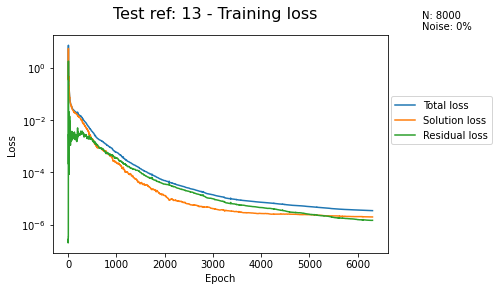

In [ ]:
# plot training loss curves
fig = utilityFunctions.trainingHistoryPlot(model.history, ['Total loss', 'Solution loss', 'Residual loss'], 'Loss', f"Test ref: {testNumber} - Training loss", yLogAx=True)

fig.text(0.98, 0.9, f'N: {N}\nNoise: {noise}%')

fig.savefig(f"/content/gdrive/My Drive/pinns/Test ref: {testNumber} - Loss curve", bbox_inches='tight')

plt.show()

In [ ]:
print(f'l1 true: {l1}')
print(f'l2 true: {l2}')

print(f'l1 predicted: {l1Pred}')
print(f'l2 predicted: {l2Pred}')

print(f'l1 % error: {l1Err:.2f}%')
print(f'l2 % error: {l2Err:.2f}%')

l1 true: 1.0
l2 true: 0.003183098861837907
l1 predicted: 0.9992032051086426
l2 predicted: 0.00329955923371017
l1 % error: 0.08%
l2 % error: 3.66%


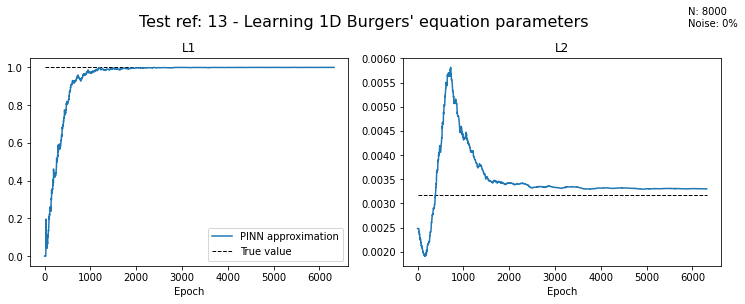

In [ ]:
fig, [l1Ax, l2Ax] = plt.subplots(1,2,
    figsize=(10, 4),
    constrained_layout=True,
    )

l1Ax.plot(model.lxHistory[:,0],
          label='PINN approximation')
l1Ax.hlines(y=l1, xmin=0, xmax=model.lxHistory.shape[0], color='k', linestyle='dashed', linewidth=1,
            label='True value')
l1Ax.set_title('L1')
l1Ax.set_xlabel('Epoch')

l1Ax.legend()

l2Ax.plot(model.lxHistory[:,1])
l2Ax.hlines(y=l2, xmin=0, xmax=model.lxHistory.shape[0], color='k', linestyle='dashed', linewidth=1) 
l2Ax.set_title('L2')
l2Ax.set_xlabel('Epoch')

fig.suptitle(f"Test ref: {testNumber} - Learning 1D Burgers' equation parameters", fontsize=16)

fig.text(0.95, 0.95, f'N: {N}\nNoise: {noise}%')

fig.savefig(f"/content/gdrive/My Drive/pinns/Test ref: {testNumber} - Learning 1D Burgers' equation parameters", bbox_inches='tight')

plt.show()

## Generate solution

In [ ]:
# compute meshgrid, solution and residual
# arguments: (model, xDim, yDim, xMin, xMax, yMin, yMax, xArg, yArg, residual=True)
mesh_x, mesh_y, PINN_solution, PINN_residual = utilityFunctions.create2dMeshData_1dBurgers(model, 1000, 1000, 0, 1, -1, 1, 't', 'x', residual=True)

relativeErr2 = np.linalg.norm(FD_solution-PINN_solution, 2) / np.linalg.norm(FD_solution, 2)

## Results

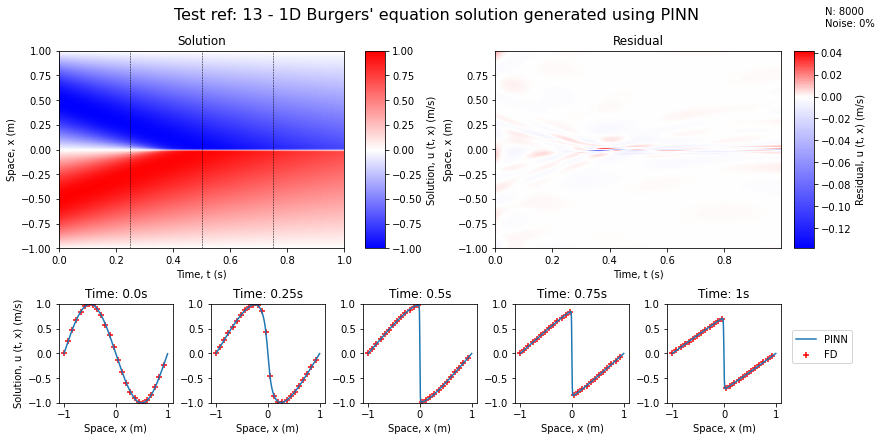

In [ ]:
# create figure using gridspec to structure subplots
fig = plt.figure(
    figsize=(12, 6),
    constrained_layout=True
    )
gs = GridSpec(3, 20, figure=fig)

# add solution plot
solutionAx = fig.add_subplot(gs[:2,:10])
solutionPlot = solutionAx.pcolormesh(mesh_x, mesh_y, PINN_solution, cmap='bwr', vmin=-1, vmax=1)
solutionAx.set_xlim([0, 1])
solutionAx.set_ylim([-1, 1])

solutionAx.set_title('Solution')
solutionAx.set_xlabel('Time, t (s)')
solutionAx.set_ylabel('Space, x (m)')
cbar = fig.colorbar(solutionPlot, use_gridspec=True)
cbar.set_label('Solution, u (t, x) (m/s)')

# add residual plot
residualAx = fig.add_subplot(gs[:2,10:])
norm = TwoSlopeNorm(vcenter=0)
residualPlot = residualAx.pcolormesh(mesh_x, mesh_y, PINN_residual, cmap='bwr', norm=norm)
residualAx.set_title('Residual')
residualAx.set_xlabel('Time, t (s)')
residualAx.set_ylabel('Space, x (m)')
cbar = fig.colorbar(residualPlot, use_gridspec=True)
cbar.set_label('Residual, u (t, x) (m/s)')

markEvery = np.arange(0, FD_solution.shape[1], 40)

# iteratively create solution snapshot subplots
for i in range(5):
    tPlot = fig.add_subplot(gs[2, i*4:(i+1)*4])    
    if i < 4:
        tPlot.plot(mesh_y[:, i*(mesh_y.shape[1]//4)], PINN_solution[:, i*(mesh_y.shape[1]//4)])

        tPlot.scatter(mesh_y[:, i*(mesh_y.shape[1]//4)][markEvery], FD_solution[:, i*(mesh_y.shape[1]//4)][markEvery],
                      s=40,
                      c='red',
                      marker='+',
                      )

        tPlot.set_title('Time: ' + str(i*mesh_x[0, mesh_x[0].shape[0]//4]) + 's')
        # add vertical lines to solution plot to indicate snapshots
        solutionAx.vlines(x=i*mesh_x[0, mesh_x[0].shape[0]//4], ymin=mesh_y[0,0], ymax=mesh_y[-1,0], colors='black', ls='--', lw=0.5)
    else:
        tPlot.plot(mesh_y[:, -1], PINN_solution[:, -1],
                   label='PINN',
                   )

        tPlot.scatter(mesh_y[:, -1][markEvery], FD_solution[:, -1][markEvery],
                      s=40,
                      c='red',
                      marker='+',
                      label='FD',
                      )
        
        tPlot.legend(loc=[1.1, 0.4])

        tPlot.set_title('Time: ' + str(tMax) + 's')
    
    tPlot.set_ylim([-1, 1])
    tPlot.set_xlabel('Space, x (m)')
    if i == 0:
        tPlot.set_ylabel('Solution, u (t, x) (m/s)')

fig.text(0.95, 0.95, f'N: {N}\nNoise: {noise}%')
# figure title
fig.suptitle(f"Test ref: {testNumber} - 1D Burgers' equation solution generated using PINN", fontsize=16)

fig.savefig(f"/content/gdrive/My Drive/pinns/Test ref: {testNumber} - 1D Burgers' solution - PINN", bbox_inches='tight')
plt.show()

In [ ]:
inverseResults = inverseResults.append({
    'Test ref': testNumber,
    'N': N,
    'Noise %': noise,
    'Terminating loss': model.history[-1,0],
    'Solution error': relativeErr2,
    'L1 error %': l1Err,
    'L2 error %': l2Err,
    },
    ignore_index=True)

inverseResults.to_csv('/content/gdrive/My Drive/pinns/1dBurgers_inv_results.csv')
inverseResults

,Test ref,N,Noise %,Terminating loss,Solution error,L1 error %,L2 error %
0,1.0,1000.0,0.0,0.000317,0.021071,2.071780,6.399129
1,2.0,1000.0,2.0,0.000416,0.004950,0.374305,4.696431
2,3.0,1000.0,4.0,0.001511,0.013743,0.066662,9.145304
3,4.0,1000.0,8.0,0.005769,0.042057,1.664710,25.309276
4,5.0,2000.0,0.0,0.000008,0.001359,0.198901,1.346342
5,6.0,2000.0,2.0,0.000410,0.003546,0.270283,0.237340
6,7.0,2000.0,4.0,0.001558,0.003804,0.208956,0.944734
7,8.0,2000.0,8.0,0.006593,0.007404,0.508267,3.607984
8,9.0,4000.0,0.0,0.000006,0.001650,0.095022,3.299206
9,10.0,4000.0,2.0,0.000412,0.001828,0.346571,2.254119


## Plot experiment results

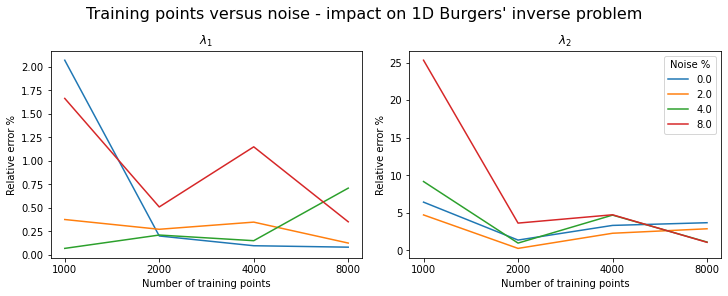

In [20]:
fig, [l1ErrAx, l2ErrAx] = plt.subplots(1, 2,
                                       figsize=(10, 4),
                                       constrained_layout=True
                                       )
xAxisLabels = 1000 * 2**np.arange(4)

sns.lineplot(
    ax=l1ErrAx,
    data=inverseResults,
    x='N',
    y='L1 error %',
    hue='Noise %',
    palette='tab10',
    legend = False,
)
l1ErrAx.set_title(r'$\lambda_{1}$')
l1ErrAx.set_xlabel('Number of training points')
l1ErrAx.set_ylabel('Relative error %')
l1ErrAx.set_xscale('log')
l1ErrAx.set_xticks(xAxisLabels)
l1ErrAx.set_xticklabels(xAxisLabels)
l1ErrAx.minorticks_off()

sns.lineplot(
    ax=l2ErrAx,
    data=inverseResults,
    x='N',
    y='L2 error %',
    hue='Noise %',
    palette='tab10',
)
l2ErrAx.set_title(r'$\lambda_{2}$')
l2ErrAx.set_xlabel('Number of training points')
l2ErrAx.set_ylabel('Relative error %')
l2ErrAx.set_xscale('log')
l2ErrAx.set_xticks(xAxisLabels)
l2ErrAx.set_xticklabels(xAxisLabels)
l2ErrAx.minorticks_off()

fig.suptitle("Training points versus noise - impact on 1D Burgers' inverse problem", fontsize=16)

fig.savefig(f"/content/gdrive/My Drive/pinns/1D Burgers' inverse experiment: NvsNoise", bbox_inches='tight')
plt.show()

## Extra

In [ ]:
fig, [l1Ax, l2Ax] = plt.subplots(1,2,
    figsize=(10, 4),
    constrained_layout=True,
    )

l1Ax.plot(model.lxHistory[:,0],
          label='PINN approximation')
l1Ax.hlines(y=l1, xmin=0, xmax=model.lxHistory.shape[0], color='k', linestyle='dashed', linewidth=1,
            label='True value')
l1Ax.set_title('L1')
l1Ax.set_xlabel('Epoch')

l1Ax.legend()

l2Ax.plot(model.lxHistory[:,1])
l2Ax.hlines(y=l2, xmin=0, xmax=model.lxHistory.shape[0], color='k', linestyle='dashed', linewidth=1) 
l2Ax.set_title('L2')
l2Ax.set_xlabel('Epoch')

fig.suptitle(f"Test ref: {testNumber} - Learning 1D Burgers' equation parameters", fontsize=16)

fig.text(0.95, 0.95, f'N: {N}\nNoise: {noise}%')

fig.savefig(f"/content/gdrive/My Drive/pinns/Test ref: {testNumber} - Learning 1D Burgers' equation parameters", bbox_inches='tight')

plt.show()

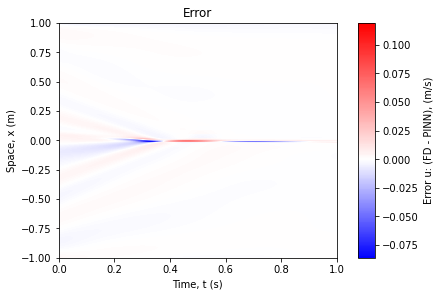

In [ ]:
fig = plt.figure(
    figsize=(6, 4),
    constrained_layout=True
    )
gs = GridSpec(1, 1, figure=fig)
norm = TwoSlopeNorm(vcenter=0)

errorAx = fig.add_subplot(gs[:,:])
errorPlot = errorAx.pcolormesh(mesh_x, mesh_y, FD_solution - PINN_solution, cmap='bwr', norm=norm)

errorAx.set_xlim([0, 1])
errorAx.set_ylim([-1, 1])

errorAx.set_title('Error')
errorAx.set_xlabel('Time, t (s)')
errorAx.set_ylabel('Space, x (m)')
cbar = fig.colorbar(errorPlot, use_gridspec=True)
cbar.set_label('Error u: (FD - PINN), (m/s)')

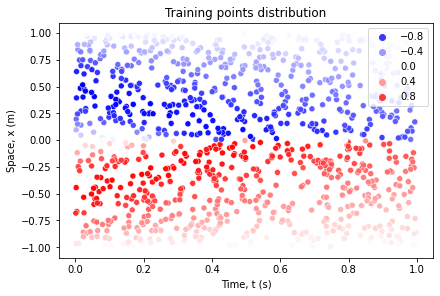

In [ ]:
fig, ax  = plt.subplots(figsize=(6, 4), constrained_layout=True)

sns.scatterplot(
    ax=ax,
    x=NArray[:,0],
    y=NArray[:,1],
    hue=NArray[:,2],
    palette='bwr',
)
# s=5.,
# c='k',
# marker='.',

ax.set_title('Training points distribution')
ax.set_xlabel('Time, t (s)')
ax.set_ylabel('Space, x (m)')
plt.show()

In [ ]:
# inverseResults = pd.DataFrame(columns=[
#     'Test ref',
#     'N',
#     'Noise %',
#     'Terminating loss',
#     'Solution error',
#     'L1 error %',
#     'L2 error %',
#     ])

# inverseResults.to_csv('/content/gdrive/My Drive/1dBurgers_inv_results.csv')